# Tiny GoogLeNet on CIFAR-10

### Import Packages

In [2]:
from drig.networks import TinyGoogLeNet
from drig.callbacks import LossAccuracyTracker, AlphaSchedulers
from drig.utils import display_image_data, plot_training_metrics, visualize_network, plot_network
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from keras.callbacks import LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.datasets import cifar10
from keras.models import load_model
import numpy as np
import os

### Initialise Paths For Dataset, Model, Training Plots & Logs

In [3]:
train_image_datum_path=os.path.abspath(os.path.join(os.path.pardir,"datasets/CIFAR-10/train"))
model_dir=os.path.abspath(os.path.join(os.path.pardir,"models/TinyGoogLeNet"))
os.makedirs(model_dir, exist_ok=True)
model_save_path=os.path.join(model_dir,"tinygooglenet_cifar10.hdf5")
loss_acc_plot_path=os.path.join(model_dir,f"loss_acc_plot_{os.getpid()}.png")
json_path=os.path.join(model_dir,f"model_history.json")

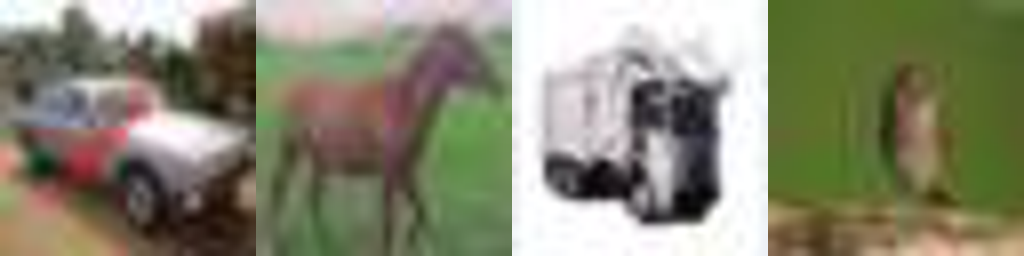

In [7]:
display_image_data(train_image_datum_path, image_dim=(256,256))

### Train-Test Split

In [4]:
((train_x,train_y),(test_x,test_y))=cifar10.load_data()

In [5]:
train_x=train_x.astype("float")
test_x=test_x.astype("float")

### Apply Mean Subtration

In [6]:
mean=np.mean(train_x, axis=0)

In [7]:
train_x-=mean
test_x-=mean

### One-Hot Encode Labels

In [8]:
label_binarizer=LabelBinarizer()
train_y=label_binarizer.fit_transform(train_y)
test_y=label_binarizer.transform(test_y)
classes=["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

### Initialize Image Augmenter

In [9]:
image_aug=ImageDataGenerator(width_shift_range=0.1,height_shift_range=0.1,horizontal_flip=True,fill_mode="nearest")

### Initialize Training Hyper-Params

In [10]:
epochs = 70
base_alpha = 5e-3
batch_size = 64

### Initialize Callbacks

In [11]:
alpha_schedulers = AlphaSchedulers(base_alpha, epochs)
callbacks=[LossAccuracyTracker(loss_acc_plot_path,json_path=json_path),
           LearningRateScheduler(alpha_schedulers.polynomial_decay)]

### Build & Compile Network

In [12]:
optimizer=SGD(learning_rate=base_alpha, momentum=0.9)
net=TinyGoogLeNet.compose(height=32,width=32,depth=3,classes=10)

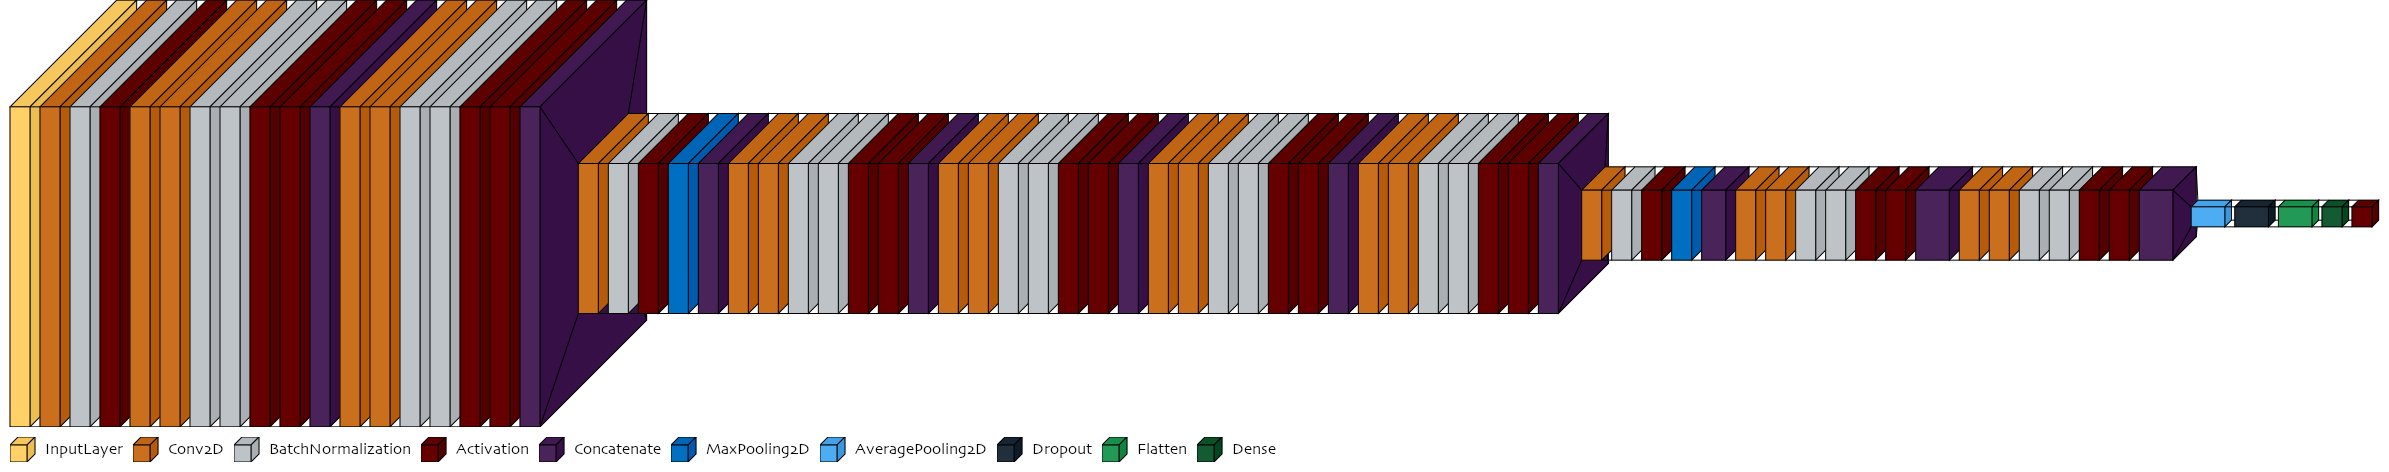

In [17]:
visualize_network(net, scale_xy=10)

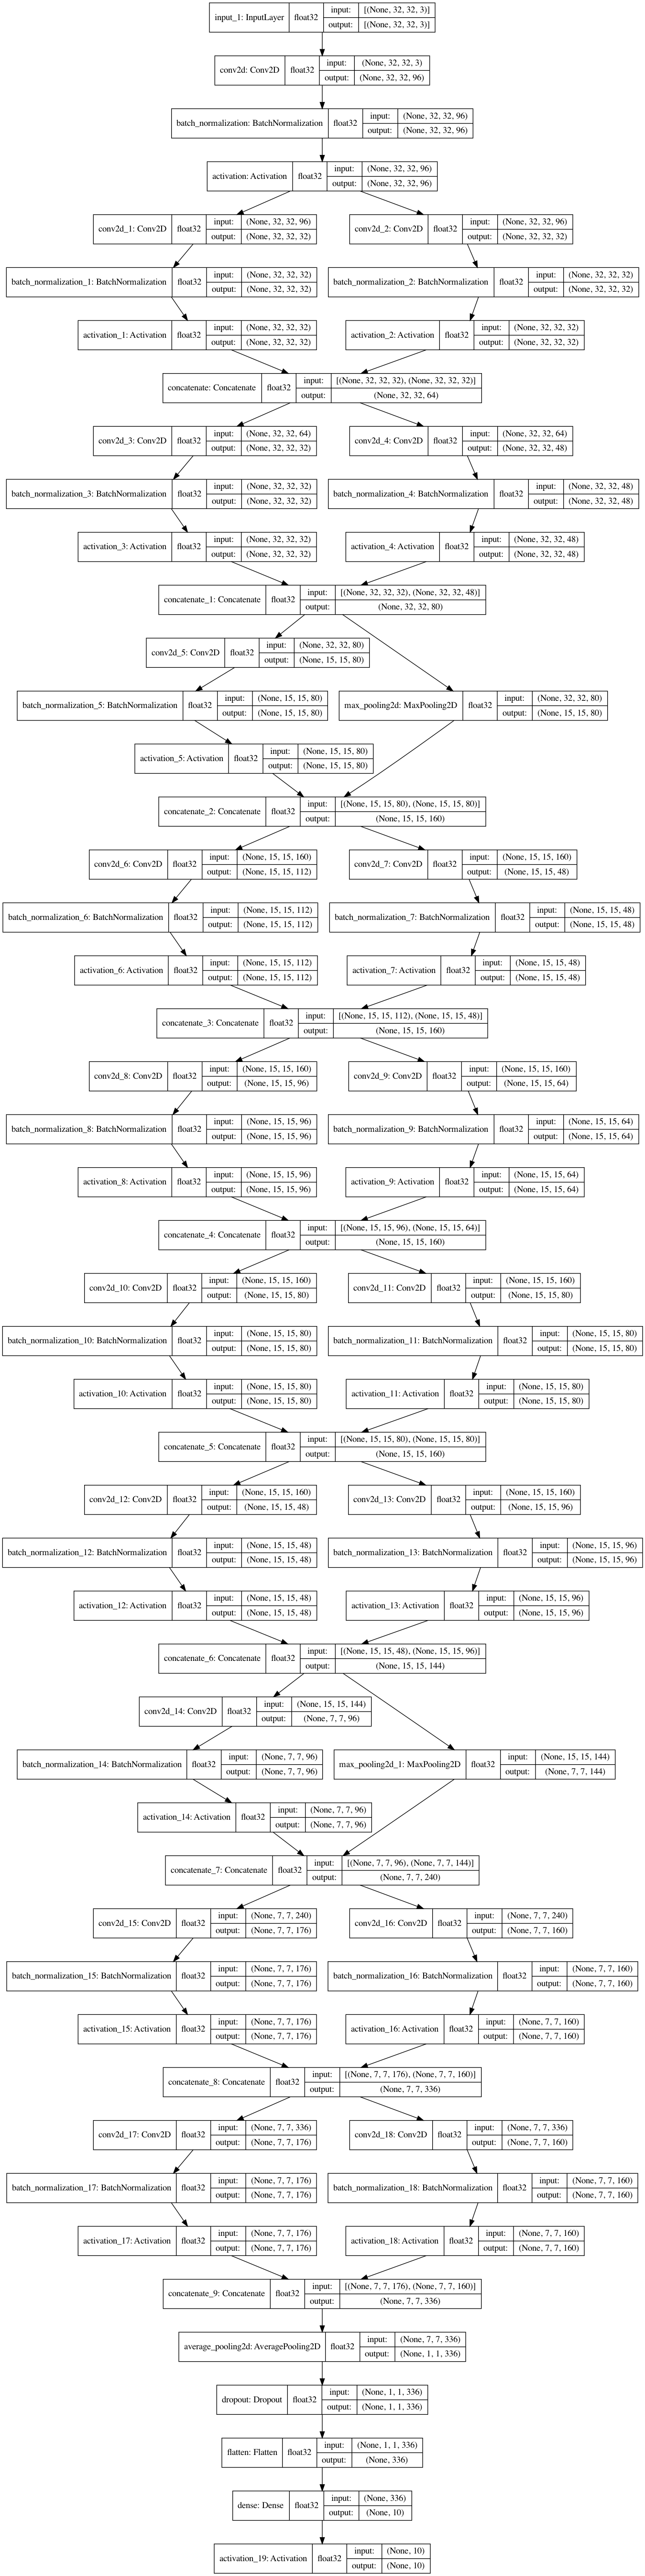

In [13]:
plot_network(net)

### Compile Network

In [14]:
net.compile(loss="categorical_crossentropy",optimizer=optimizer, metrics=["accuracy"])

### Train Network

In [17]:
Z=net.fit(image_aug.flow(train_x,train_y, batch_size=batch_size), validation_data=(test_x,test_y), 
        steps_per_epoch=len(train_x)//batch_size, 
        epochs=epochs,callbacks=callbacks, verbose=1)

### Run Predictions On Test Set


In [19]:
cifar10_predictions=net.predict(test_x, batch_size=batch_size)

In [22]:
print(classification_report(test_y.argmax(axis=1), cifar10_predictions.argmax(axis=1), target_names=classes))

              precision    recall  f1-score   support

    airplane       0.91      0.92      0.92      1000
  automobile       0.95      0.96      0.96      1000
        bird       0.87      0.86      0.86      1000
         cat       0.82      0.81      0.81      1000
        deer       0.88      0.90      0.89      1000
         dog       0.88      0.82      0.85      1000
        frog       0.88      0.94      0.91      1000
       horse       0.93      0.91      0.92      1000
        ship       0.95      0.95      0.95      1000
       truck       0.94      0.94      0.94      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



### Plot Training Statistics

In [23]:
plot_training_metrics(model_training_history=Z,epochs=epochs,inline=True)